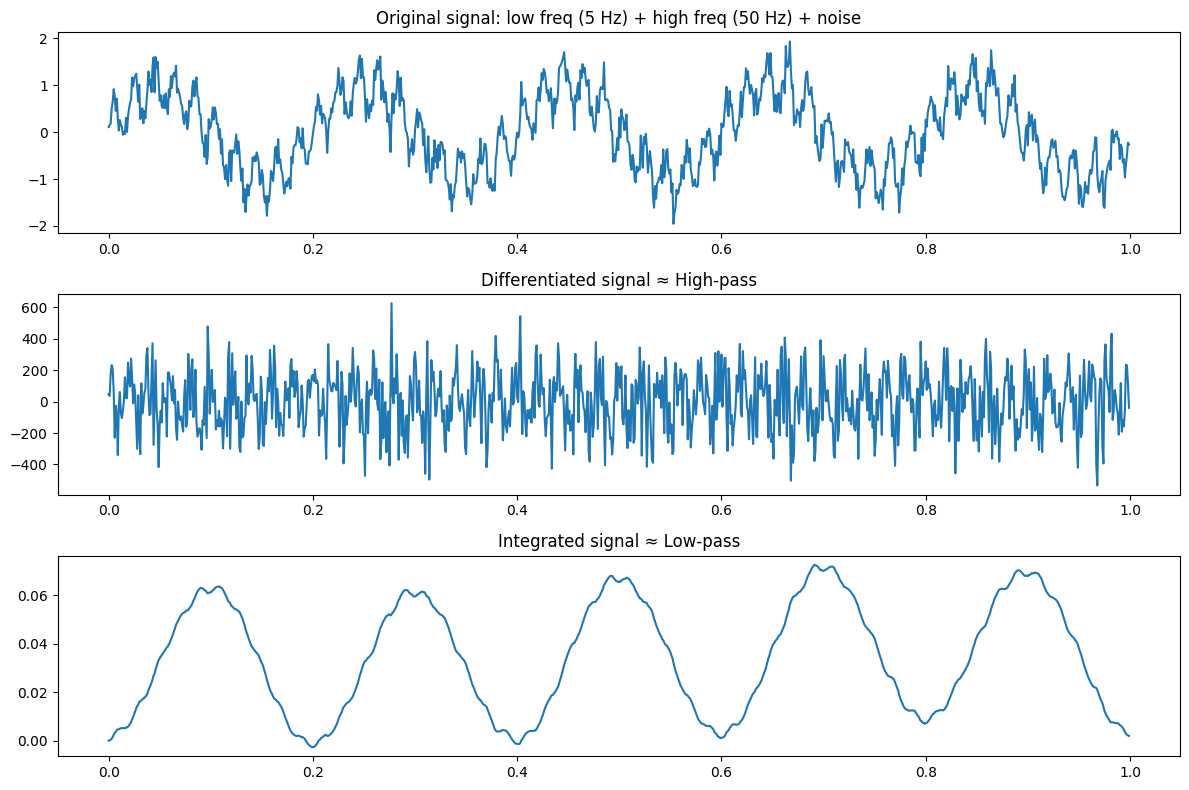

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Time axis
t = np.linspace(0, 1, 1000, endpoint=False)
# Signal: low freq sine + high freq sine + noise
x = np.sin(2*np.pi*5*t) + 0.5*np.sin(2*np.pi*50*t) + 0.2*np.random.randn(len(t))

# Differentiation (high-pass effect)
dt = t[1] - t[0]
x_diff = np.gradient(x, dt)

# Integration (low-pass effect, cumulative integral)
x_int = np.cumsum(x) * dt

# Plot
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(t, x)
plt.title("Original signal: low freq (5 Hz) + high freq (50 Hz) + noise")

plt.subplot(3,1,2)
plt.plot(t, x_diff)
plt.title("Differentiated signal ≈ High-pass")

plt.subplot(3,1,3)
plt.plot(t, x_int)
plt.title("Integrated signal ≈ Low-pass")

plt.tight_layout()
plt.show()


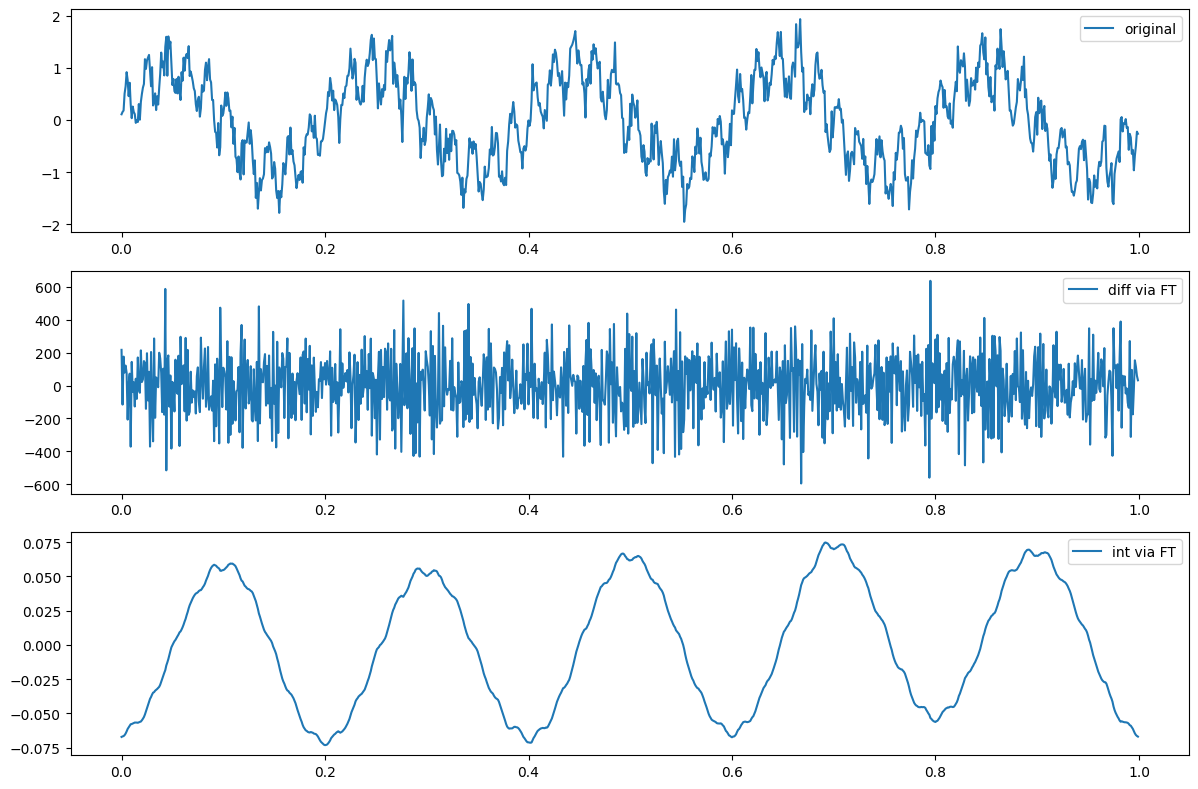

In [16]:
# Fourier transform demonstration

# Compute Fourier transform
X = np.fft.fft(x)
freqs = np.fft.fftfreq(len(t), dt * 2)

# Differentiation in Fourier domain: multiply by j*ω
X_diff_ft = 1j * 2 * np.pi * freqs * X
x_diff_ft = np.fft.ifft(X_diff_ft).real

# Integration in Fourier domain: divide by j*ω (careful at ω=0)
X_int_ft = np.zeros_like(X, dtype=complex)
eps = 1e-6
X_int_ft[1:] = X[1:] / (1j * 2 * np.pi * freqs[1:])
x_int_ft = np.fft.ifft(X_int_ft).real

# Plot comparison
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(t, x, label="original")
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, x_diff_ft, label="diff via FT")
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, x_int_ft, label="int via FT")
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, ifft, fftfreq

class FilterComparison:
    def __init__(self, fs=1000, duration=2):
        """
        Initialize the filter comparison class
        
        Args:
            fs: Sampling frequency (Hz)
            duration: Signal duration (seconds)
        """
        self.fs = fs
        self.duration = duration
        self.dt = 1/fs
        self.t = np.linspace(0, duration, int(fs * duration), endpoint=False)
        
    def create_test_signal(self):
        """Create a test signal with multiple frequency components"""
        # Composite signal with different frequencies
        signal_low = np.sin(2 * np.pi * 5 * self.t)      # 5 Hz
        signal_mid = np.sin(2 * np.pi * 50 * self.t)     # 50 Hz  
        signal_high = np.sin(2 * np.pi * 200 * self.t)   # 200 Hz
        noise = 0.1 * np.random.randn(len(self.t))
        
        return signal_low + signal_mid + signal_high + noise
    
    def integration_lowpass(self, signal, cutoff_freq):
        """
        Low-pass filter using integration (accumulation)
        Integration in time domain = low-pass filtering
        """
        # Simple integration using cumulative sum
        integrated = np.cumsum(signal) * self.dt
        
        # Apply scaling factor based on cutoff frequency
        # This is a simple approximation - real RC filters have exponential response
        alpha = 2 * np.pi * cutoff_freq * self.dt
        alpha = min(alpha, 1.0)  # Prevent instability
        
        # Exponential smoothing (approximates RC low-pass filter)
        filtered = np.zeros_like(signal)
        filtered[0] = signal[0]
        for i in range(1, len(signal)):
            filtered[i] = alpha * signal[i] + (1 - alpha) * filtered[i-1]
            
        return filtered
    
    def differentiation_highpass(self, signal, cutoff_freq):
        """
        High-pass filter using differentiation
        Differentiation in time domain = high-pass filtering
        """
        # Simple differentiation using numpy gradient
        diff_signal = np.gradient(signal, self.dt)
        
        # Apply scaling and DC blocking
        # High-pass filter removes low frequencies (including DC)
        tau = 1 / (2 * np.pi * cutoff_freq)  # Time constant
        alpha = self.dt / (self.dt + tau)
        
        # Digital high-pass filter implementation
        filtered = np.zeros_like(signal)
        for i in range(1, len(signal)):
            filtered[i] = alpha * (filtered[i-1] + signal[i] - signal[i-1])
            
        return filtered
    
    def fft_lowpass(self, signal, cutoff_freq):
        """FFT-based low-pass filter"""
        # Compute FFT
        signal_fft = fft(signal)
        freqs = fftfreq(len(signal), self.dt)
        
        # Create low-pass filter mask
        mask = np.abs(freqs) <= cutoff_freq
        
        # Apply filter in frequency domain
        filtered_fft = signal_fft * mask
        
        # Convert back to time domain
        filtered = np.real(ifft(filtered_fft))
        
        return filtered
    
    def fft_highpass(self, signal, cutoff_freq):
        """FFT-based high-pass filter"""
        # Compute FFT
        signal_fft = fft(signal)
        freqs = fftfreq(len(signal), self.dt)
        
        # Create high-pass filter mask
        mask = np.abs(freqs) >= cutoff_freq
        
        # Apply filter in frequency domain
        filtered_fft = signal_fft * mask
        
        # Convert back to time domain
        filtered = np.real(ifft(filtered_fft))
        
        return filtered
    
    def butterworth_filters(self, sig, cutoff_freq, filter_type='low'):
        """Reference Butterworth filters for comparison"""
        nyquist = self.fs / 2
        normal_cutoff = cutoff_freq / nyquist
        
        # Design Butterworth filter
        b, a = signal.butter(4, normal_cutoff, btype=filter_type, analog=False)
        
        # Apply filter
        filtered = signal.filtfilt(b, a, sig)
        
        return filtered
    
    def analyze_frequency_response(self, original, filtered, title):
        """Analyze and plot frequency response"""
        # Compute FFT for both signals
        orig_fft = fft(original)
        filt_fft = fft(filtered)
        freqs = fftfreq(len(original), self.dt)
        
        # Only positive frequencies
        pos_mask = freqs >= 0
        freqs_pos = freqs[pos_mask]
        orig_fft_pos = orig_fft[pos_mask]
        filt_fft_pos = filt_fft[pos_mask]
        
        # Compute magnitude response
        orig_mag = np.abs(orig_fft_pos)
        filt_mag = np.abs(filt_fft_pos)
        
        # Plot
        plt.figure(figsize=(12, 8))
        
        # Time domain
        plt.subplot(2, 2, 1)
        plt.plot(self.t[:500], original[:500], 'b-', label='Original', alpha=0.7)
        plt.plot(self.t[:500], filtered[:500], 'r-', label='Filtered', linewidth=2)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title(f'{title} - Time Domain')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Frequency domain
        plt.subplot(2, 2, 2)
        plt.semilogy(freqs_pos[:len(freqs_pos)//2], orig_mag[:len(orig_mag)//2], 'b-', label='Original')
        plt.semilogy(freqs_pos[:len(freqs_pos)//2], filt_mag[:len(filt_mag)//2], 'r-', label='Filtered')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(f'{title} - Frequency Response')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Filter transfer function
        plt.subplot(2, 2, 3)
        transfer_func = np.divide(filt_mag, orig_mag, out=np.zeros_like(filt_mag), where=orig_mag!=0)
        plt.plot(freqs_pos[:len(freqs_pos)//2], transfer_func[:len(transfer_func)//2], 'g-', linewidth=2)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('|H(f)|')
        plt.title('Filter Transfer Function')
        plt.grid(True, alpha=0.3)
        
        # Phase response
        plt.subplot(2, 2, 4)
        orig_phase = np.angle(orig_fft_pos)
        filt_phase = np.angle(filt_fft_pos)
        phase_diff = filt_phase - orig_phase
        plt.plot(freqs_pos[:len(freqs_pos)//2], np.unwrap(phase_diff[:len(phase_diff)//2]), 'purple', linewidth=2)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Phase Difference (rad)')
        plt.title('Phase Response')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compare_all_filters(self):
        """Compare all filter implementations"""
        # Create test signal
        test_signal = self.create_test_signal()
        
        # Filter parameters
        lp_cutoff = 30  # Hz
        hp_cutoff = 40  # Hz
        
        print("Comparing Filter Implementations")
        print("=" * 50)
        print(f"Low-pass cutoff: {lp_cutoff} Hz")
        print(f"High-pass cutoff: {hp_cutoff} Hz")
        print(f"Sampling frequency: {self.fs} Hz")
        
        # Low-pass filters
        lp_integration = self.integration_lowpass(test_signal, lp_cutoff)
        lp_fft = self.fft_lowpass(test_signal, lp_cutoff)
        lp_butterworth = self.butterworth_filters(test_signal, lp_cutoff, 'low')
        
        # High-pass filters  
        hp_differentiation = self.differentiation_highpass(test_signal, hp_cutoff)
        hp_fft = self.fft_highpass(test_signal, hp_cutoff)
        hp_butterworth = self.butterworth_filters(test_signal, hp_cutoff, 'high')
        
        # Analyze each filter
        self.analyze_frequency_response(test_signal, lp_integration, 'Integration-based Low-pass')
        self.analyze_frequency_response(test_signal, lp_fft, 'FFT-based Low-pass')
        self.analyze_frequency_response(test_signal, lp_butterworth, 'Butterworth Low-pass')
        
        self.analyze_frequency_response(test_signal, hp_differentiation, 'Differentiation-based High-pass')
        self.analyze_frequency_response(test_signal, hp_fft, 'FFT-based High-pass')
        self.analyze_frequency_response(test_signal, hp_butterworth, 'Butterworth High-pass')
        
        # Direct comparison plot
        self.plot_filter_comparison(test_signal, lp_cutoff, hp_cutoff)
    
    def plot_filter_comparison(self, signal, lp_cutoff, hp_cutoff):
        """Plot direct comparison of all filter types"""
        # Apply all filters
        lp_int = self.integration_lowpass(signal, lp_cutoff)
        lp_fft = self.fft_lowpass(signal, lp_cutoff)
        hp_diff = self.differentiation_highpass(signal, hp_cutoff)
        hp_fft = self.fft_highpass(signal, hp_cutoff)
        
        plt.figure(figsize=(15, 10))
        
        # Time domain comparison
        plt.subplot(2, 2, 1)
        plt.plot(self.t[:500], signal[:500], 'k-', label='Original', alpha=0.5)
        plt.plot(self.t[:500], lp_int[:500], 'b-', label='Integration LP')
        plt.plot(self.t[:500], lp_fft[:500], 'r--', label='FFT LP')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Low-pass Filter Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 2)
        plt.plot(self.t[:500], signal[:500], 'k-', label='Original', alpha=0.5)
        plt.plot(self.t[:500], hp_diff[:500], 'g-', label='Differentiation HP')
        plt.plot(self.t[:500], hp_fft[:500], 'm--', label='FFT HP')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('High-pass Filter Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Frequency domain comparison
        freqs = fftfreq(len(signal), self.dt)
        pos_mask = freqs >= 0
        freqs_pos = freqs[pos_mask]
        
        plt.subplot(2, 2, 3)
        orig_fft = np.abs(fft(signal))[pos_mask]
        lp_int_fft = np.abs(fft(lp_int))[pos_mask]
        lp_fft_fft = np.abs(fft(lp_fft))[pos_mask]
        
        plt.semilogy(freqs_pos[:len(freqs_pos)//2], orig_fft[:len(orig_fft)//2], 'k-', label='Original')
        plt.semilogy(freqs_pos[:len(freqs_pos)//2], lp_int_fft[:len(lp_int_fft)//2], 'b-', label='Integration LP')
        plt.semilogy(freqs_pos[:len(freqs_pos)//2], lp_fft_fft[:len(lp_fft_fft)//2], 'r--', label='FFT LP')
        plt.axvline(lp_cutoff, color='red', linestyle=':', alpha=0.7, label=f'Cutoff {lp_cutoff}Hz')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('Low-pass Frequency Response')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 4)
        hp_diff_fft = np.abs(fft(hp_diff))[pos_mask]
        hp_fft_fft = np.abs(fft(hp_fft))[pos_mask]
        
        plt.semilogy(freqs_pos[:len(freqs_pos)//2], orig_fft[:len(orig_fft)//2], 'k-', label='Original')
        plt.semilogy(freqs_pos[:len(freqs_pos)//2], hp_diff_fft[:len(hp_diff_fft)//2], 'g-', label='Differentiation HP')
        plt.semilogy(freqs_pos[:len(freqs_pos)//2], hp_fft_fft[:len(hp_fft_fft)//2], 'm--', label='FFT HP')
        plt.axvline(hp_cutoff, color='magenta', linestyle=':', alpha=0.7, label=f'Cutoff {hp_cutoff}Hz')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('High-pass Frequency Response')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def demonstrate_theory(self):
        """Demonstrate the theoretical relationship between integration/differentiation and filtering"""
        print("\nTHEORETICAL RELATIONSHIPS:")
        print("=" * 50)
        print("1. INTEGRATION → LOW-PASS FILTERING")
        print("   • Integration in time domain = division by jω in frequency domain")
        print("   • |H(ω)| = 1/|ω| → Low frequencies pass, high frequencies attenuated")
        print("   • Phase: -π/2 (90° lag)")
        print()
        print("2. DIFFERENTIATION → HIGH-PASS FILTERING") 
        print("   • Differentiation in time domain = multiplication by jω in frequency domain")
        print("   • |H(ω)| = |ω| → High frequencies pass, low frequencies attenuated")
        print("   • Phase: +π/2 (90° lead)")
        print()
        print("3. FFT FILTERING")
        print("   • Direct frequency domain manipulation")
        print("   • Sharp cutoff possible (brick-wall filter)")
        print("   • Can cause ringing due to Gibbs phenomenon")
        print()
        
        # Demonstrate with simple example
        t = np.linspace(0, 2, 1000)
        dt = t[1] - t[0]
        
        # Simple sine wave
        f0 = 5  # Hz
        x = np.sin(2 * np.pi * f0 * t)
        
        # Integration and differentiation
        x_int = np.cumsum(x) * dt
        x_diff = np.gradient(x, dt)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.plot(t, x, 'b-', linewidth=2)
        plt.title('Original: sin(2πft)')
        plt.xlabel('Time (s)')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        plt.plot(t, x_int, 'r-', linewidth=2)
        plt.title('Integration: -cos(2πft)/(2πf)')
        plt.xlabel('Time (s)')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        plt.plot(t, x_diff, 'g-', linewidth=2)
        plt.title('Differentiation: 2πf·cos(2πft)')
        plt.xlabel('Time (s)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


THEORETICAL RELATIONSHIPS:
1. INTEGRATION → LOW-PASS FILTERING
   • Integration in time domain = division by jω in frequency domain
   • |H(ω)| = 1/|ω| → Low frequencies pass, high frequencies attenuated
   • Phase: -π/2 (90° lag)

2. DIFFERENTIATION → HIGH-PASS FILTERING
   • Differentiation in time domain = multiplication by jω in frequency domain
   • |H(ω)| = |ω| → High frequencies pass, low frequencies attenuated
   • Phase: +π/2 (90° lead)

3. FFT FILTERING
   • Direct frequency domain manipulation
   • Sharp cutoff possible (brick-wall filter)
   • Can cause ringing due to Gibbs phenomenon



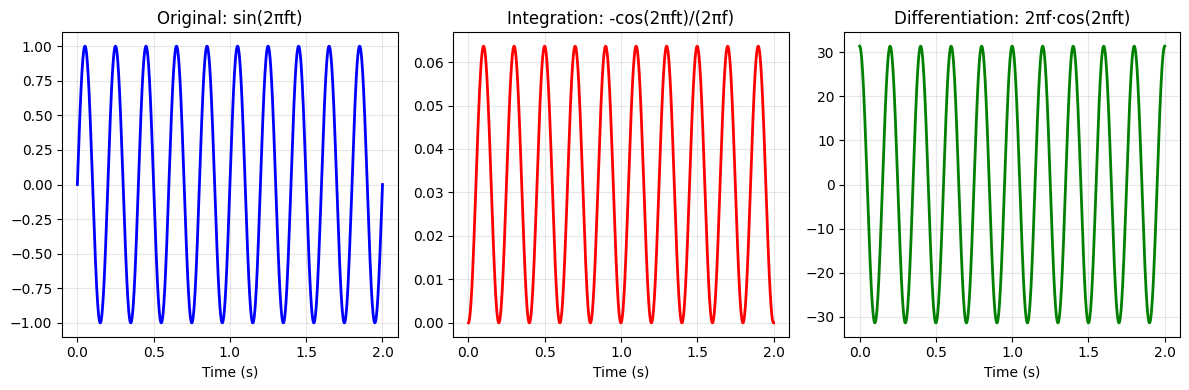

Comparing Filter Implementations
Low-pass cutoff: 30 Hz
High-pass cutoff: 40 Hz
Sampling frequency: 1000 Hz


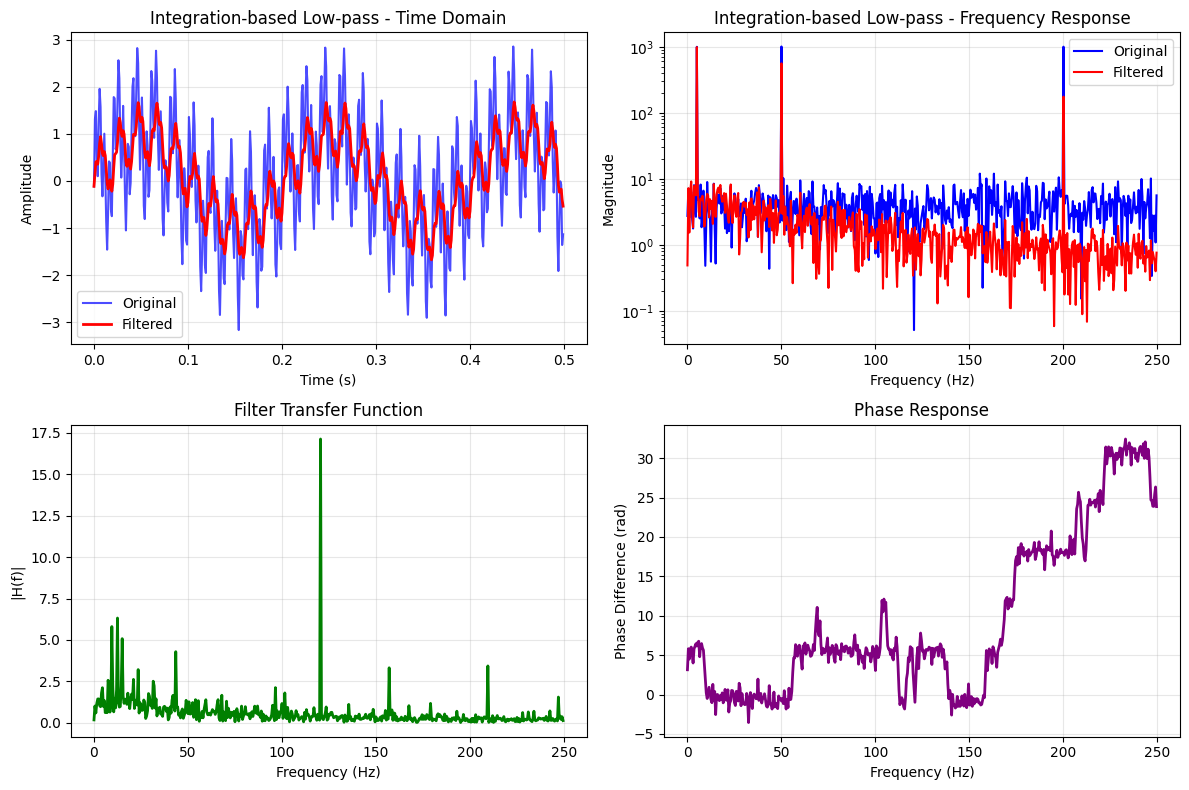

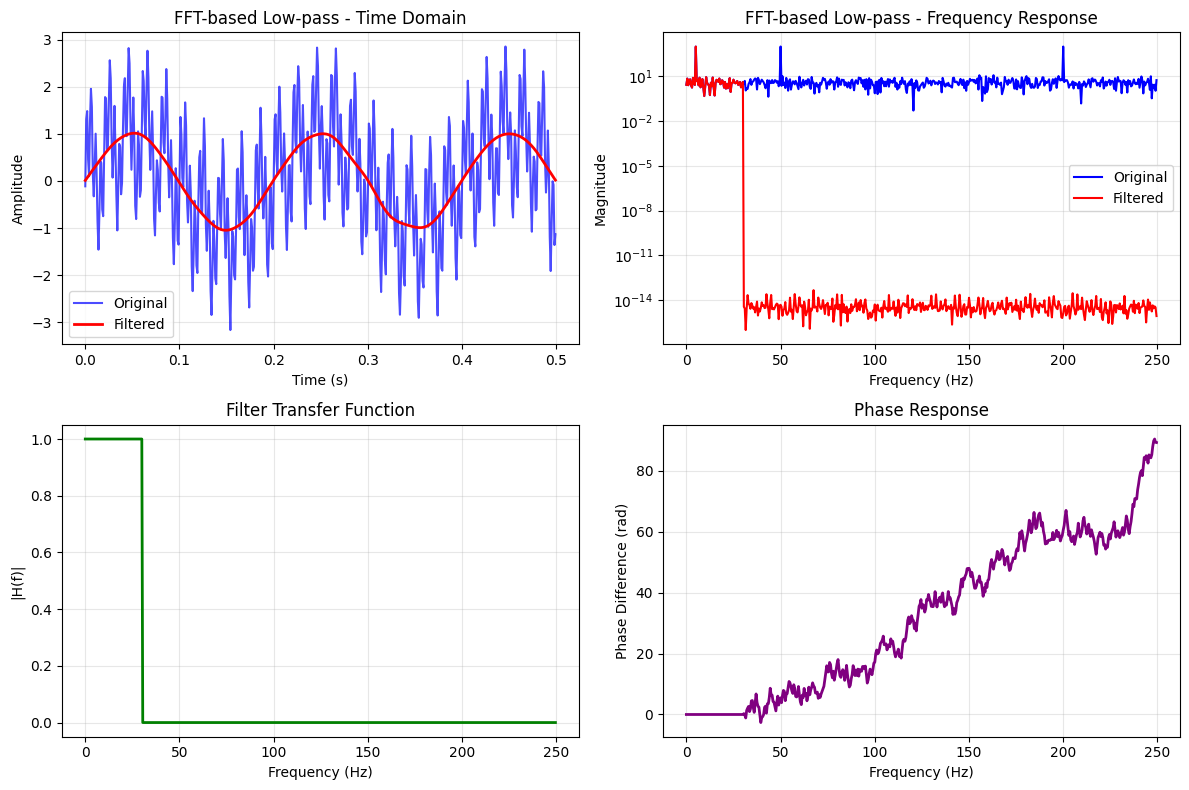

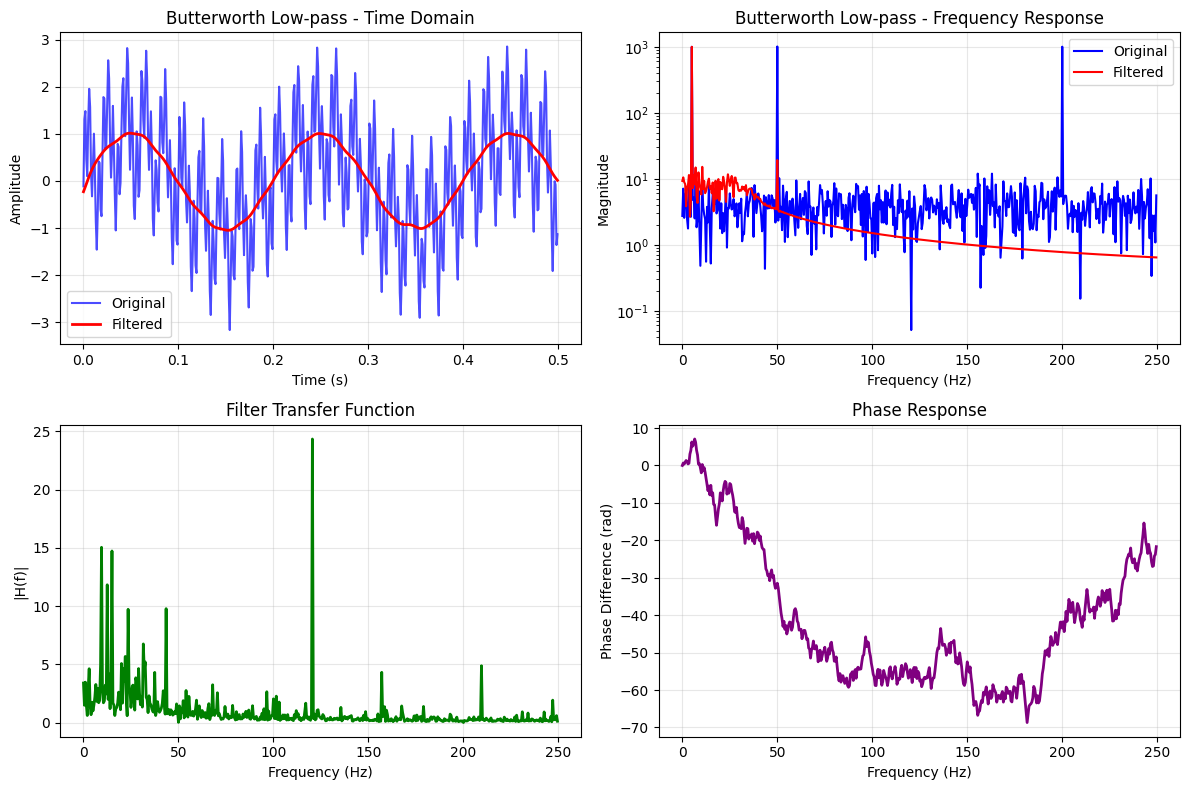

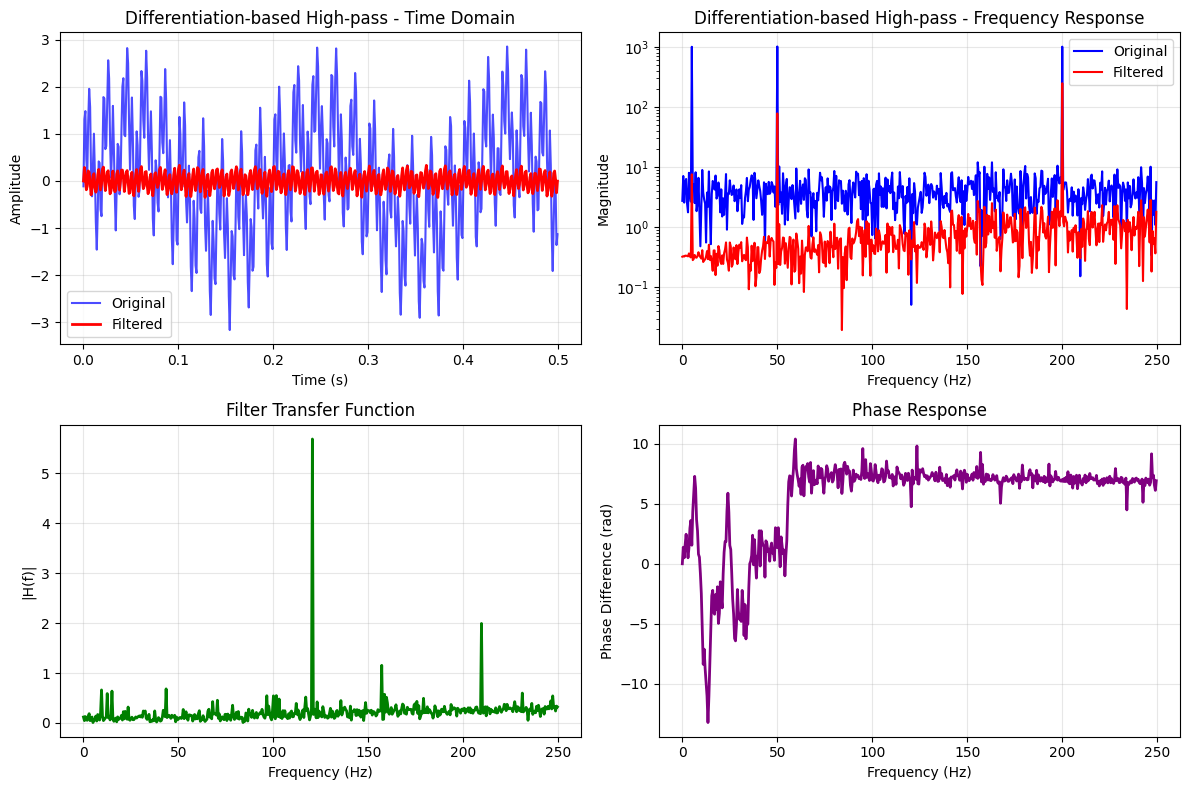

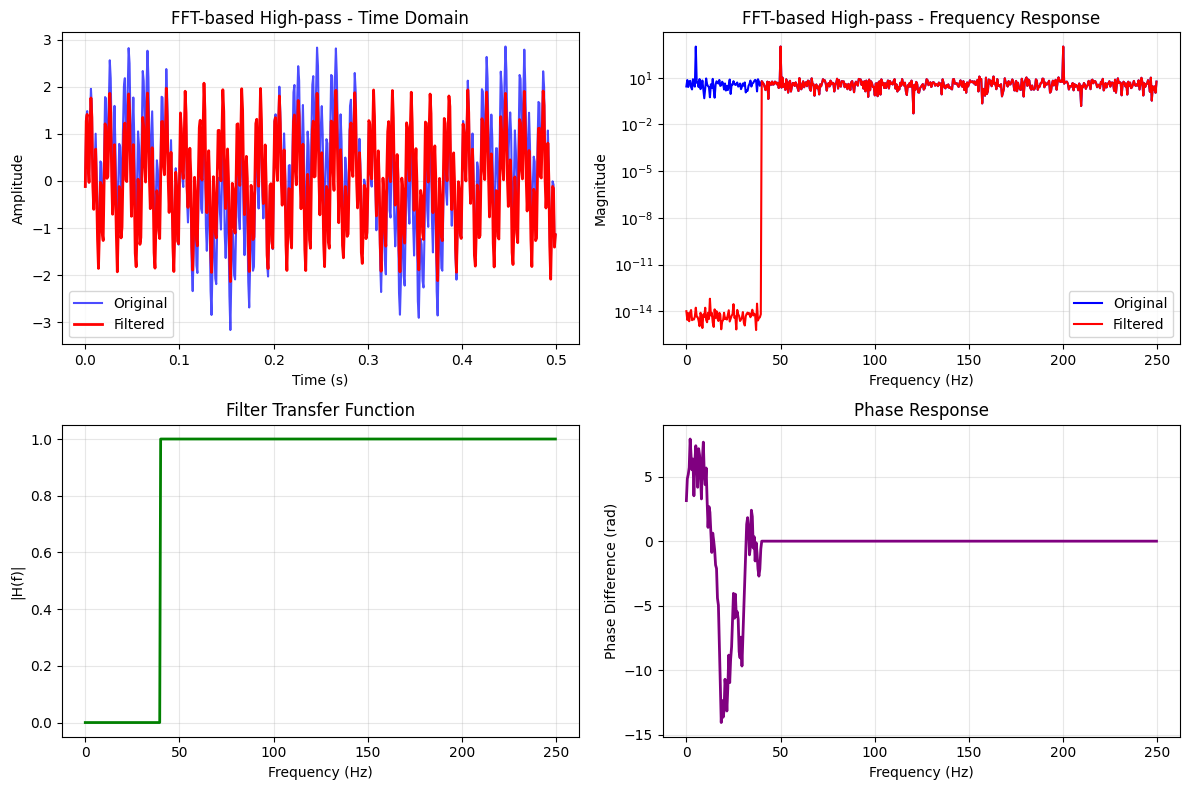

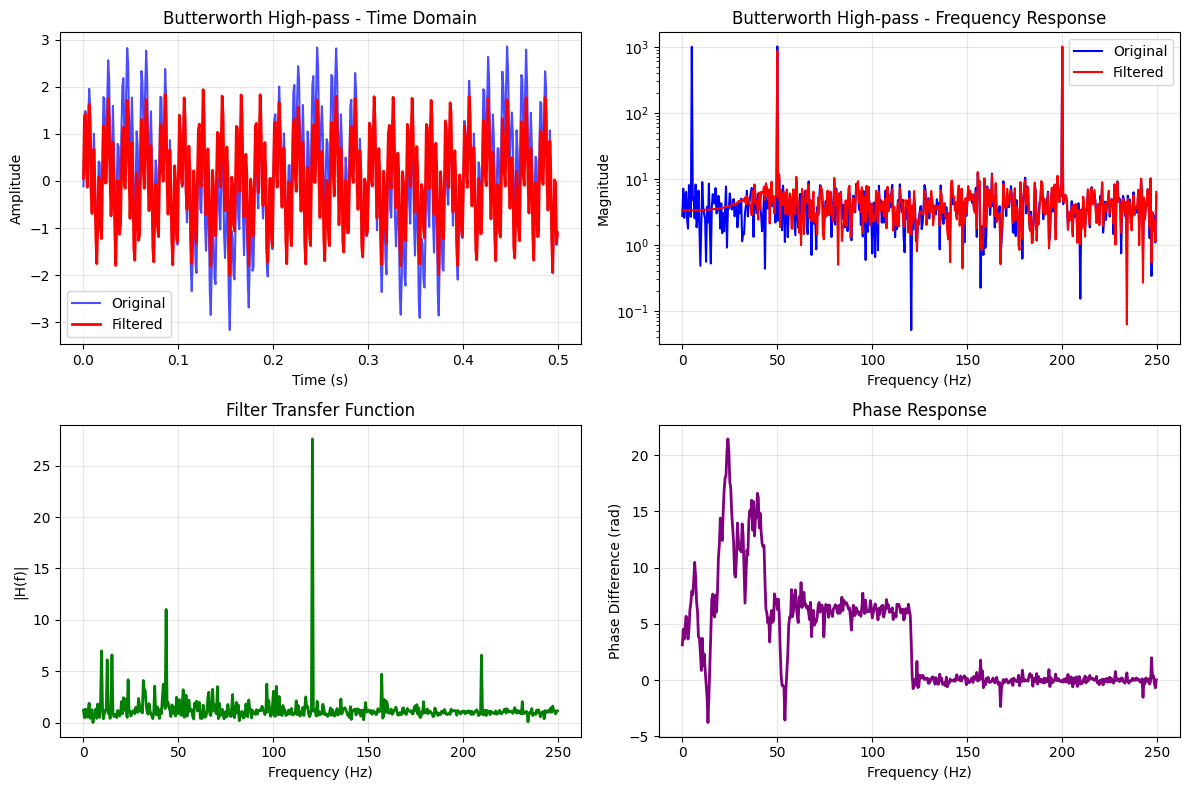

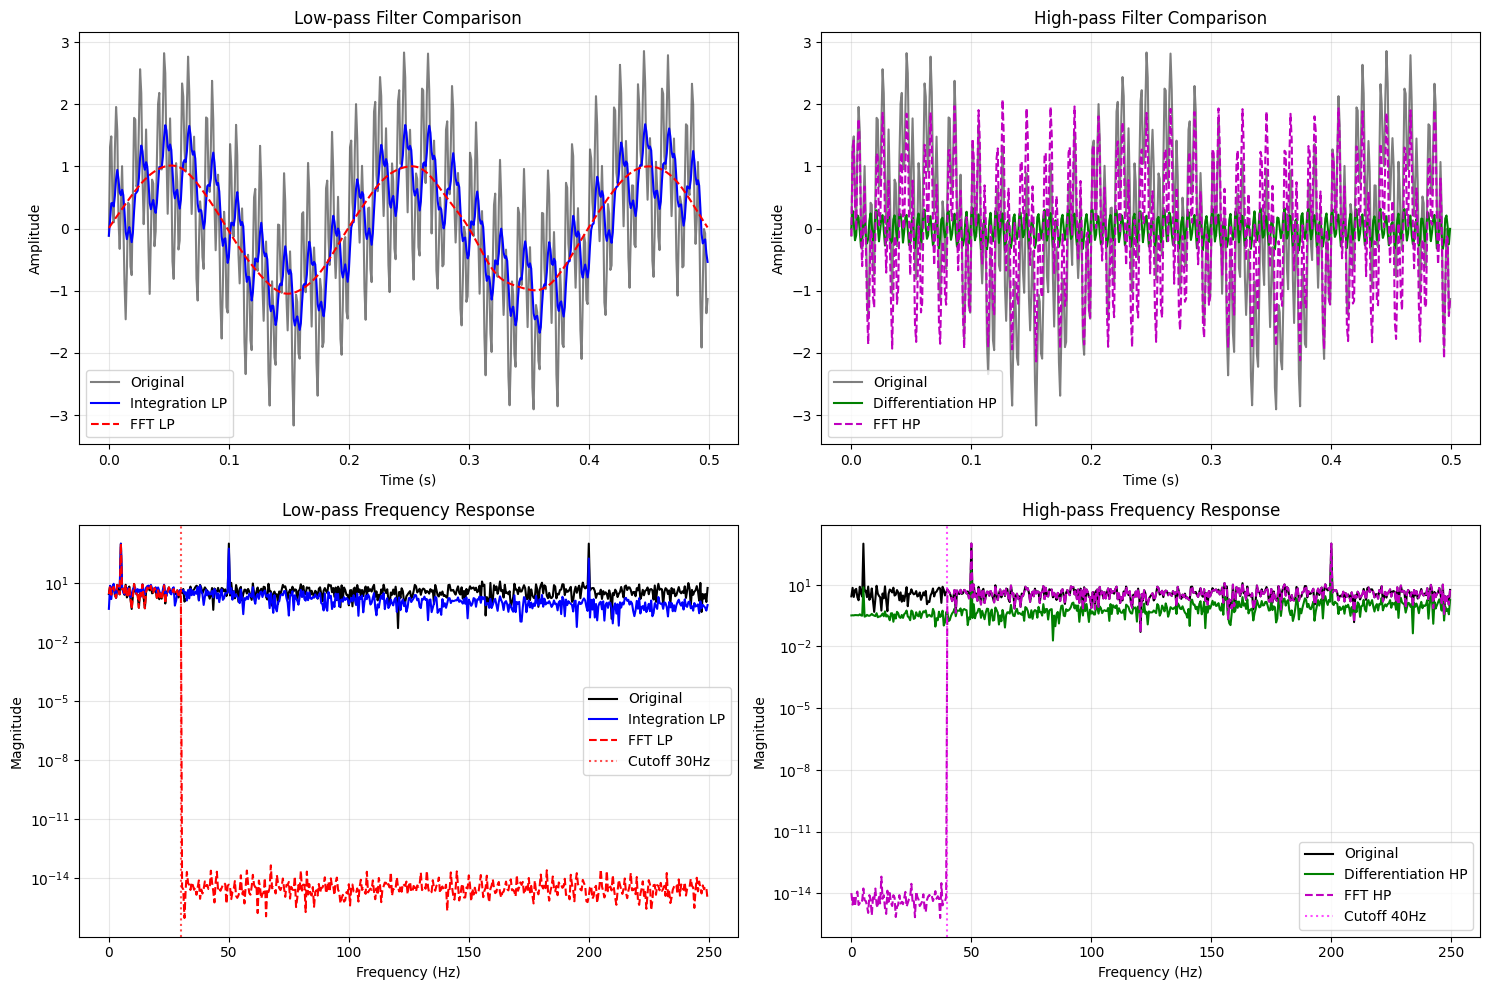

In [20]:
# Create filter comparison instance
filter_comp = FilterComparison(fs=1000, duration=2)

# Demonstrate theory
filter_comp.demonstrate_theory()

# Compare all filter implementations
filter_comp.compare_all_filters()